# Toxic Comment Classification
## Problem Statement

A prevalent challenge faced on online discussion platforms is moderating user-generated content to maintain respectful and inclusive conversations. Toxic comments — those that are rude, disrespectful, threatening, or hateful — can discourage participation, silence vulnerable users, and harm community engagement.  

The goal of this project is to **develop a machine learning model capable of automatically detecting multiple types of toxic behavior in online comments**, including threats, obscenity, insults, and identity-based hate. The dataset, sourced from Wikipedia talk page discussions, contains user comments labeled across several toxicity categories.  

By accurately identifying toxic language, the model can support moderation tools like Google’s *Perspective API*, helping platforms foster healthier online discourse. This work contributes to the broader effort of building AI systems that enhance communication quality without stifling free expression.

### Objectives
- **Classify** comments into multiple toxicity categories (multi-label classification).  
- **Analyze** comment patterns, length, and word usage across toxic and non-toxic texts.  
- **Build and evaluate** traditional machine learning models using TF-IDF features.  
- **Prepare** the model for deployment via a FastAPI web service.

### Motivation
Effective automated toxicity detection is essential for scaling community moderation. Existing systems, while valuable, often misclassify context-sensitive language or fail to distinguish between types of toxicity. This project aims to build a transparent, reproducible baseline using classical ML techniques, forming a foundation for more advanced NLP methods in the future.

### Dataset Overview
- **Source:** Toxic Comment Classification Challenge, from Kaggle. 
- **Samples:** ~150k user comments (train + test)  
- **Labels:**  
  - `toxic`  
  - `severe_toxic`  
  - `obscene`  
  - `threat`  
  - `insult`  
  - `identity_hate`  
- **Type:** Multi-label classification (a comment may belong to multiple classes)

### Libraries

In [1]:
import re
from bs4 import BeautifulSoup
import zipfile
import nltk
import unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from contractions import CONTRACTION_MAP
import spacy
from tqdm.notebook import tqdm
import joblib
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Data Wrangling

In [3]:
# to inspect the content of the zipfile that holds our data
with zipfile.ZipFile('./data/jigsaw-toxic-comment-classification-challenge.zip') as zip:
    print('Zipped file contents as a table:')
    print(zip.printdir())
    print('\nZipped file contents as a list:')
    print(zip.namelist())
    # then extract the needed files which are 'test.csv.zip' and 'train.zip.csv'
    zip.extract('train.csv.zip', path='./data')

Zipped file contents as a table:
File Name                                             Modified             Size
sample_submission.csv.zip                      2019-12-11 04:00:40      1459715
test.csv.zip                                   2019-12-11 04:00:42     24577258
test_labels.csv.zip                            2019-12-11 04:00:52      1527605
train.csv.zip                                  2019-12-11 04:00:52     27619914
None

Zipped file contents as a list:
['sample_submission.csv.zip', 'test.csv.zip', 'test_labels.csv.zip', 'train.csv.zip']


In [4]:
def load_csv_from_zip(zip_path): 
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0] 
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

In [5]:
df_train = load_csv_from_zip('./data/train.csv.zip')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


From the information and the few rows examined, we can see the columns: 'id', 'comment_text', and the classifications. The `comment_text` column is the most important one here. Next we would look at the first 5 comments in the training set.

In [8]:
for i in range(5):
    print(f"{i+1}: {df_train['comment_text'].iloc[i]}")
    print('\n')

1: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


2: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


3: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.


4: "
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

We can see that some of the comments have some unnecessary elements, and need cleaning. Next we will move on to preprocessing of the text.

## Text Preprocessing

First, we will remove some of the noise in the dataset. This includes things like dates, newlines, possible urls, and the likes. To do this, we will first take a sample of the dataset and examine it for any sort of noise that would not contribute much to the data. Already we have seen an IP address in one of the first comments inspected. We will examine 25 random samples and note the noise to be removed.

In [9]:
sample_size = 25
sample_comments = df_train['comment_text'].sample(sample_size, random_state=42)

for i, comment in enumerate(sample_comments):
    print(f'{i + 1}: {comment}\n{'-' * 120}')

1: Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?
------------------------------------------------------------------------------------------------------------------------
2: Carioca RFA 

Thanks for your support on my request for adminship.

The final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!
------------------------------------------------------------------------------------------------------------------------
3: "

 Birthday 

No worries, It's what I do ;)Enjoy ur day|talk|e "
------------------------------------------------------------------------------------------------------------------------
4: 

As can be seen, some elements like:
- IP Address
- Links
- Timestamps (including or excluding dates.)
- Newlines (`\n`)

seem like noise, and would not really have an impact on our classification.

So, I would create regex patterns to remove such instances.

In [10]:
def remove_html_tags(text):
    try:
        text = BeautifulSoup(text, "lxml").get_text()
    except Exception:
        # if BeautifulSoup fails for a particular string, leave text as-is
        pass
    return text

def remove_ips(text):
    """Remove IP addresses like 192.168.0.1."""
    return re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', text)

def remove_full_timestamp(text):
    """Remove full timestamps or date-time combinations like '12:30, 9 October 2007 (UTC)'."""
    return re.sub(r'(?:\d{1,2}:\d{2},?\s*)?(?:\d{1,2}\s\w+,?\s\d{4},?|\w+\s\d{1,2},?\s\d{4},?)(?:\s\([A-Z]{2,4}\))?', '', text)

def remove_timestamp(text):
    """Remove short timestamps like '12:45'."""
    return re.sub(r'\d{1,2}:\d{2}', '', text)

def remove_link(text):
    """Remove URLs starting with http or https."""
    return re.sub(r'https?://\S+', '', text)

def clean_markup_and_quotes(text, start_zone=3):
    """
    This function handles newlines, quotes, stray markup and formatting inconsistencies. It inncludes context-aware newline handling to maintain sentence boundaries.
    """

    # Remove leading commas and extra spaces
    text = re.sub(r'^[,\s]+', '', text)

    # Context-aware newline replacement
    def _newline_repl(match):
        start = match.start()
        if start < start_zone:
            return ''
        prev_char = text[start - 1]
        return ' ' if prev_char in '.!?' else '. '

    text = re.sub(r'\n+', _newline_repl, text)

    # Remove initial stray period and whitespace
    text = re.sub(r'^\s*\.\s*', '', text)

    # Remove various forms of quotation marks and backticks
    text = re.sub(r'[\"\u2018\u2019\u201C\u201D`]', '', text)

    # Remove square brackets and stray hyphens
    text = re.sub(r'[\[\]]+', '', text)
    text = re.sub(r'^\-+\s*', '', text)

    # Remove trailing unmatched parentheses
    text = re.sub(r'\)+\s*$', '', text)

    # Collapse multiple spaces and strip outer whitespace
    text = re.sub(r'\s{2,}', ' ', text).strip()

    return text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def clean_text(text):
    """Full cleaning pipeline."""
    text = remove_html_tags(text)
    text = remove_ips(text)
    text = remove_link(text)
    text = remove_full_timestamp(text)
    text = remove_timestamp(text)
    text = clean_markup_and_quotes(text)
    text = remove_accented_chars(text)
    return text

So, we will test the full cleaning pipeline, `clean_text`, using the sample comments we retrieved from our dataset.

In [11]:
cleaned_sample_comments = sample_comments.apply(clean_text)

for i, comment in enumerate(cleaned_sample_comments):
    print(f'{i+1}:{comment}\n')

1:Geez, are you forgetful! We've already discussed why Marx was not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.' Ergo, he is a statist - the opposite of an anarchist. I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat. Would you call him a vegetarian?

2:Carioca RFA . Thanks for your support on my request for adminship. The final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!

3:Birthday . No worries, It's what I do ;)Enjoy ur day|talk|e

4:Pseudoscience category? . I'm assuming that this article is in the pseudoscience category because of its association with creationism. However, there are modern, scientifically-accepted variants of catastrophism that have nothing to do with creationism  and they're even mentioned in the article! I think the connection to pseudoscience needs to be clarified, or the article mad

Next, I will expand contractions in the text. I will be using the dictionary `CONTRACTIONS_MAP` from the `contractions.py` module graciously created by Dipanja Sarkar and made open-source.

In [12]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    # expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

Again, we would test this on the sample comments.

In [13]:
cleaned_sample_comments = cleaned_sample_comments.apply(expand_contractions)

for i, comment in enumerate(cleaned_sample_comments):
    print(f'{i+1}:{comment}\n')

1:Geez, are you forgetful! We have already discussed why Marx was not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.' Ergo, he is a statist - the opposite of an anarchist. I know a guy who says that, when he gets old and his teeth fall out, he will quit eating meat. Would you call him a vegetarian?

2:Carioca RFA . Thanks for your support on my request for adminship. The final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!

3:Birthday . No worries, It is what I do ;)Enjoy ur day|talk|e

4:Pseudoscience category? . I am assuming that this article is in the pseudoscience category because of its association with creationism. However, there are modern, scientifically-accepted variants of catastrophism that have nothing to do with creationism  and they are even mentioned in the article! I think the connection to pseudoscience needs to be clarified, or the arti

Next, I would perform `lemmatization` on the text. `Lemmatization` is a more formal process for finding the root of a word (also known as the `lemma`), compared to `stemming`. It does this by analyzing the word's morphology using vocabulary from a dictionary. I will utilize `spaCy` in performing this task.

In [14]:
def lemmatize_texts(texts):
    lemmatized = []

    for doc in nlp.pipe(texts, batch_size=1000):
        lem = ' '.join([token.lemma_ if token.lemma_ !='-PRON' else token.text for token in doc])
        lemmatized.append(lem)

    return lemmatized

In [15]:
cleaned_sample_comments = pd.Series(lemmatize_texts(cleaned_sample_comments.tolist()))

for i, comment in enumerate(cleaned_sample_comments):
    print(f'{i+1}:{comment}\n')

1:Geez , be you forgetful ! we have already discuss why Marx be not an anarchist , i.e. he want to use a state to mold his ' socialist man . ' Ergo , he be a statist - the opposite of an anarchist . I know a guy who say that , when he get old and his tooth fall out , he will quit eat meat . would you call he a vegetarian ?

2:carioca RFA . thank for your support on my request for adminship . the final outcome be ( 31/4/1 ) , so I be now an administrator . if you have any comment or concern on my action as an administrator , please let I know . thank you !

3:birthday . no worry , it be what I do ;) enjoy ur day|talk|e

4:pseudoscience category ? . I be assume that this article be in the pseudoscience category because of its association with creationism . however , there be modern , scientifically - accept variant of catastrophism that have nothing to do with creationism   and they be even mention in the article ! I think the connection to pseudoscience need to be clarify , or the artic

Next, I would remove special characters. These characters do little to improve text interpretability and just add to the noise.

In [16]:
def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [17]:
# test
cleaned_sample_comments = cleaned_sample_comments.apply(remove_special_characters)

for i, comment in enumerate(cleaned_sample_comments):
    print(f'{i+1}:{comment}\n')

1:Geez  be you forgetful  we have already discuss why Marx be not an anarchist  ie he want to use a state to mold his  socialist man   Ergo  he be a statist  the opposite of an anarchist  I know a guy who say that  when he get old and his tooth fall out  he will quit eat meat  would you call he a vegetarian 

2:carioca RFA  thank for your support on my request for adminship  the final outcome be  3141   so I be now an administrator  if you have any comment or concern on my action as an administrator  please let I know  thank you 

3:birthday  no worry  it be what I do  enjoy ur daytalke

4:pseudoscience category   I be assume that this article be in the pseudoscience category because of its association with creationism  however  there be modern  scientifically  accept variant of catastrophism that have nothing to do with creationism   and they be even mention in the article  I think the connection to pseudoscience need to be clarify  or the article make more general and less creationis

Next, I will remove stopwords. Stopwords are words that have little or no importance in the extraction of meaning from text. They usually have the highest frequency amongst words in a corpus. Examples are 'a', 'an', etc.

In [18]:
def remove_stopwords(text, is_lower_case=False):
    tokens =  tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# example
remove_stopwords("The, and, if, are stopwords. Samuel is not")

', , , stopwords. Samuel not'

In [19]:
# test
cleaned_sample_comments = cleaned_sample_comments.apply(remove_stopwords)

for i, comment in enumerate(cleaned_sample_comments):
    print(f'{i+1}:{comment}\n')

1:Geez forgetful already discuss Marx not anarchist ie want use state mold socialist man Ergo statist opposite anarchist know guy say get old tooth fall quit eat meat would call vegetarian

2:carioca RFA thank support request adminship final outcome 3141 administrator comment concern action administrator please let know thank

3:birthday no worry enjoy ur daytalke

4:pseudoscience category assume article pseudoscience category association creationism however modern scientifically accept variant catastrophism nothing creationism even mention article think connection pseudoscience need clarify article make general less creationism specific category tag remove entirely

5:phrase exist would provide search engine even mention page not available whole

6:Ps delta function use example Kronecker delta not Dirac delta Kronecker delta whereas Dirac delta not L201 incidentally response request example L2X not RKHS x open subset hand hardy space usually rkhs use various variant Szego kernel examp

Next I would create a function to clean the text of excessively long words.

In [20]:
def remove_very_long_tokens(text):
    return re.sub(r'\w{30,}|(.{1,5})\1{10,}', '', text)

Lastly, I would combine all of the preprocessing steps, which are:
- Removing HTML tags and links
- Removing Dates and timestamps
- Removing IPs
- Removing noise like markups, quotation marks, unnecessary brackets
- Removing accented characters
- Expanding contractions
- Lemmatization
- Removal of special characters
- Removal of stopwords

Now, I will combine all these processes into one preprocessing function, that will take in text from our dataset and return a refined version of the text.

In [21]:
def text_preprocessor(df):
    s = df['comment_text']

    s = s.parallel_apply(clean_text)
    s = s.parallel_apply(expand_contractions)

    # batch lemmatization
    s = pd.Series(lemmatize_texts(s.tolist()), index=s.index)

    s = s.parallel_apply(remove_special_characters)
    s = s.parallel_apply(remove_stopwords)
    s = s.parallel_apply(remove_very_long_tokens)

    df['cleaned_comment_text'] = s
    return df

In [22]:
df_train = text_preprocessor(df_train)

Now we will examine the preprocessing that has been done on the retrieved sample comments.

In [23]:
sample_comments_idx = sample_comments.index
preprocessed_sample_comments = df_train['cleaned_comment_text'].iloc[sample_comments_idx]

for i, comment in enumerate(preprocessed_sample_comments):
    print(f'{i}: {comment}\n')

0: Geez forgetful already discuss Marx not anarchist ie want use state mold socialist man Ergo statist opposite anarchist know guy say get old tooth fall quit eat meat would call vegetarian

1: carioca RFA thank support request adminship final outcome 3141 administrator comment concern action administrator please let know thank

2: birthday no worry enjoy ur daytalke

3: pseudoscience category assume article pseudoscience category association creationism however modern scientifically accept variant catastrophism nothing creationism even mention article think connection pseudoscience need clarify article make general less creationism specific category tag remove entirely

4: phrase exist would provide search engine even mention page not available whole

5: Ps delta function use example Kronecker delta not Dirac delta Kronecker delta whereas Dirac delta not L201 incidentally response request example L2X not RKHS x open subset hand hardy space usually rkhs use various variant Szego kernel

The preprocessing pipeline has yielded a normalized comment corpus. However, there might have been some comments that would have ended up as being empty, or null. I would test for such comments, and remove them.

In [24]:
df_train = df_train.replace(r'^(\s?)+$', np.nan, regex=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    159571 non-null  object
 1   comment_text          159571 non-null  object
 2   toxic                 159571 non-null  int64 
 3   severe_toxic          159571 non-null  int64 
 4   obscene               159571 non-null  int64 
 5   threat                159571 non-null  int64 
 6   insult                159571 non-null  int64 
 7   identity_hate         159571 non-null  int64 
 8   cleaned_comment_text  159307 non-null  object
dtypes: int64(6), object(3)
memory usage: 11.0+ MB


In the `cleaned_comment_text` column, we can see that its original count has reduced, as a result of the preprocessing. Since it is the important feature, I would remove all the rows with null values to make the dataset congruent.

In [25]:
df_train = df_train.dropna().reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159307 entries, 0 to 159306
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    159307 non-null  object
 1   comment_text          159307 non-null  object
 2   toxic                 159307 non-null  int64 
 3   severe_toxic          159307 non-null  int64 
 4   obscene               159307 non-null  int64 
 5   threat                159307 non-null  int64 
 6   insult                159307 non-null  int64 
 7   identity_hate         159307 non-null  int64 
 8   cleaned_comment_text  159307 non-null  object
dtypes: int64(6), object(3)
memory usage: 10.9+ MB


Lastly, I would save the preprocessed dataset in a `CSV` file so that I do not need to run the preprocessing pipeline everytime, as it takes quite some time for the data to be preprocessed (about 30 minutes or thereabout).

In [26]:
df_train.to_csv('data/clean_toxic_comment_dataset.csv', index=False)
print("Cleaned Dataset Saved!")

Cleaned Dataset Saved!


In [27]:
df_train = pd.read_csv('data/clean_toxic_comment_dataset.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159307 entries, 0 to 159306
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    159307 non-null  object
 1   comment_text          159307 non-null  object
 2   toxic                 159307 non-null  int64 
 3   severe_toxic          159307 non-null  int64 
 4   obscene               159307 non-null  int64 
 5   threat                159307 non-null  int64 
 6   insult                159307 non-null  int64 
 7   identity_hate         159307 non-null  int64 
 8   cleaned_comment_text  159307 non-null  object
dtypes: int64(6), object(3)
memory usage: 10.9+ MB


## EDA

This section aims to carry out basic exploratory data analysis on the text data with the aim of uncovering insights and patterns that may be hidden within it. First, I will create a couple of new features that give us some insight into the dataset. The features are `length of text`, `word count`, and `mean word count`.

In [28]:
def word_count(text: str):
    # this creates a count of the words in a comment
    return len(text.split())

def mean_word_length(text: str):
    # this averages over the length of all the words in a comment
    words = text.split()
    if not words:   # for when a row is empty
        return 0
    return np.mean([len(word)for word in words])

def feature_columns(df, col='cleaned_comment_text'):
    # number of characters
    df['length'] = df[col].str.len()
    # word count
    df['word_count'] = df[col].parallel_apply(word_count)
    # mean word length
    df['mean_word_length'] = df[col].parallel_apply(mean_word_length)
    return df

In [29]:
df_train = feature_columns(df_train)

In [30]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment_text,length,word_count,mean_word_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation edit make username Hardcore Metall...,160,25,5.440000
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,Daww match background colour seemingly stuck t...,55,8,6.000000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really not try edit war guy constantly...,135,22,5.181818
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,not make real suggestion improvement wonder se...,330,50,5.600000
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page,29,5,5.000000


I will plot a histogram of the text length.

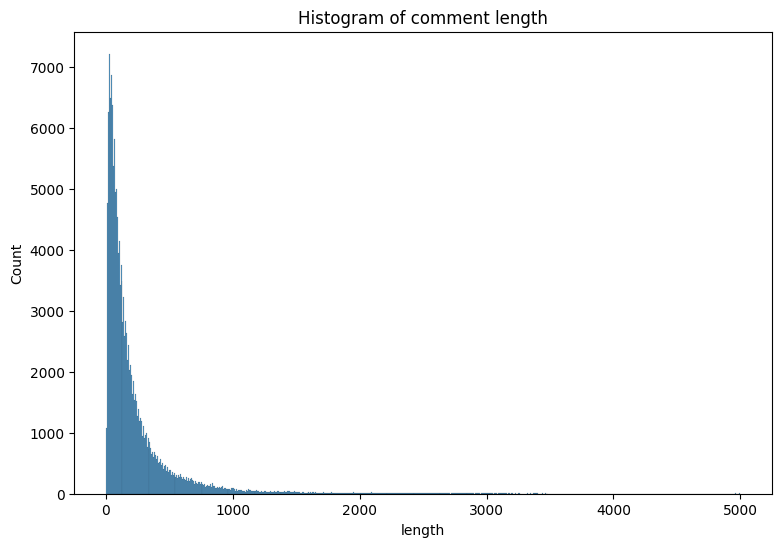

In [31]:
fig = plt.figure(figsize=(9, 6))
sns.histplot(df_train['length'])
plt.title("Histogram of comment length");

From the histogram we can see that the almost all of comments have between 0 and 1000 characters. Next I will create an histogram of the average word length.

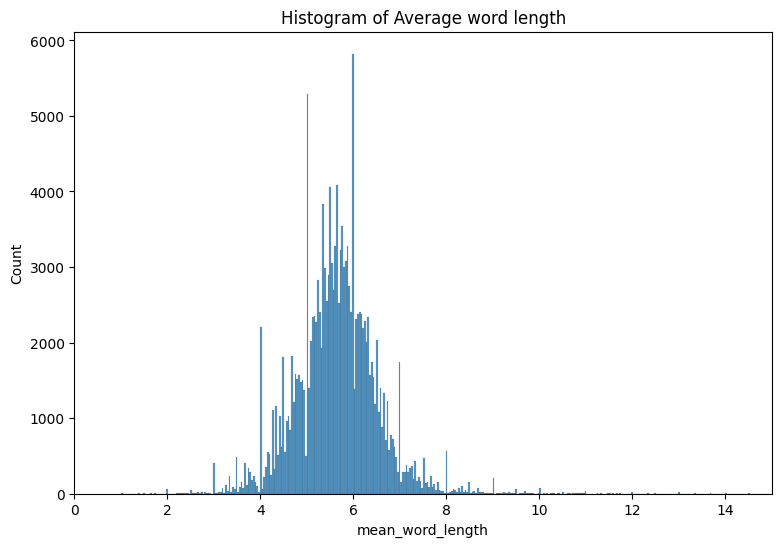

In [32]:
fig = plt.figure(figsize=(9, 6))
sns.histplot(df_train['mean_word_length'])
plt.xlim((0, 15))
plt.title("Histogram of Average word length");

From this, we can see that the average word length per comment is between 4 to 8 characters. We will visualize the summary statistics of the column using a boxplot.

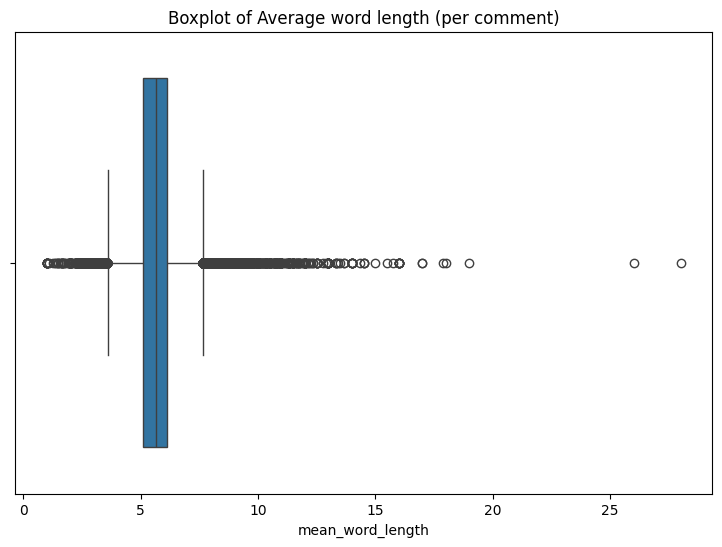

In [33]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=df_train, x='mean_word_length')
plt.title("Boxplot of Average word length (per comment)");

Lastly, a histogram of `word_count`, which is the number of words in a comment.

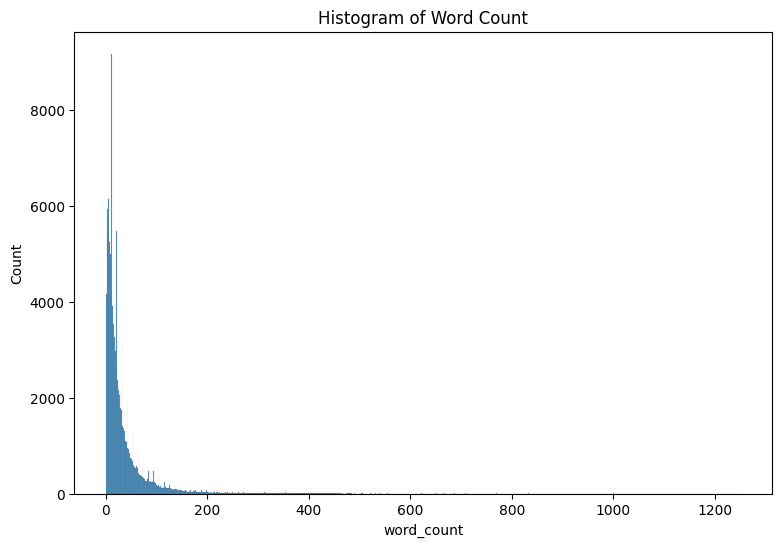

In [34]:
plt.figure(figsize=(9, 6))
sns.histplot(x='word_count', data=df_train)
plt.title("Histogram of Word Count");

The distribution of word count is very similar to that of the length of the comment. An overwhelming majority of comments have between 0 and 200 words, as can be seen above. Next I will visualize the categories of the dataset.

In [35]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

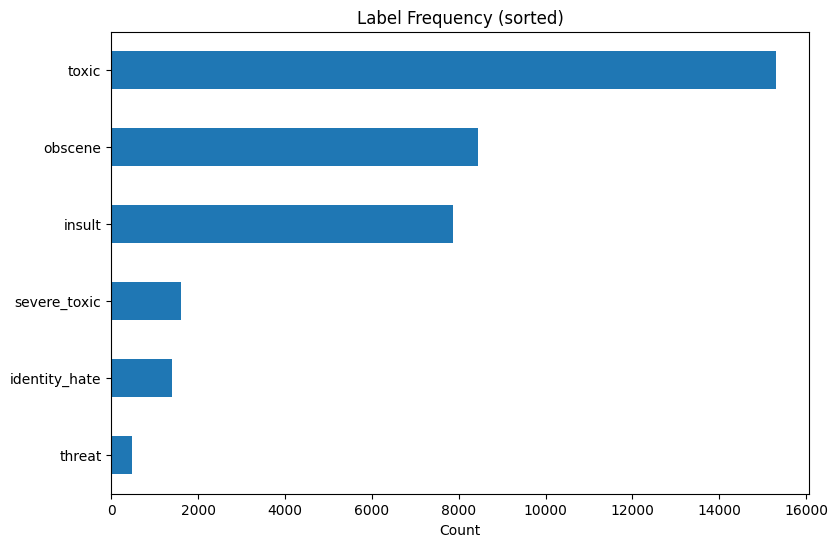

In [36]:
plt.figure(figsize=(9, 6))
df_train[label_cols].sum().sort_values().plot(kind='barh')
plt.title("Label Frequency (sorted)")
plt.xlabel("Count")
plt.show()

The horizontal bar chart above shows that the `toxic` label is the most common label by far, with almost `16,000` comments deemed toxic. The least common is `threat`, which not up to a thousand comments are labeled as such. This is not to be seen as some sort of class distribution, as some of the comments might have more than one label, i.e. a comment could be both `toxic` and a  `threat`. I will look at comments that are classified into more than one category.

In [37]:
# first, a 'clean' feature denoting the comments that are not toxic
df_train['clean'] = (df_train[label_cols].sum(axis=1) == 0).astype(int)

In [38]:
# create a column that shows the number of labels a comment has
df_train['num_labels'] = df_train[label_cols].sum(axis=1)

I will use this to calculate the label cardinality. This is the average number of labels per comment.

In [39]:
label_cardinality = df_train['num_labels'].mean()
print(f'The average number of labels per comment is {round(label_cardinality, 3)}.')

The average number of labels per comment is 0.22.


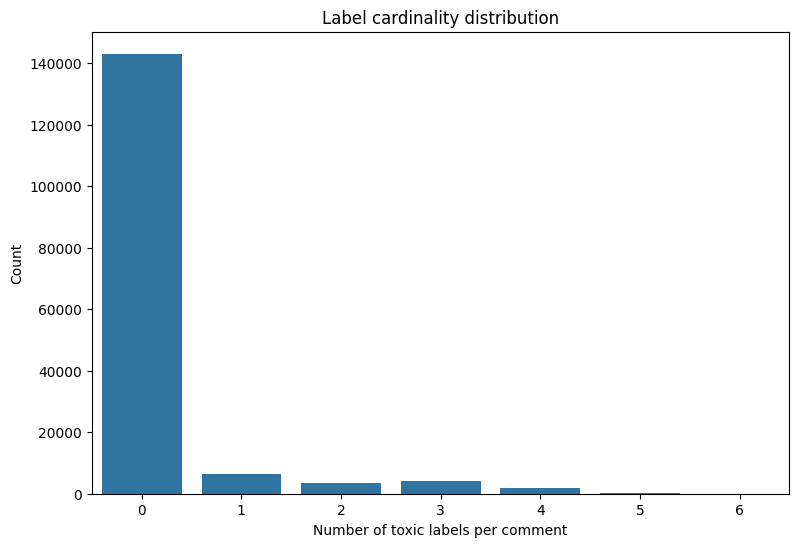

In [40]:
# to visualize the number of labels per comment:
plt.figure(figsize=(9, 6))

sns.countplot(x='num_labels', data=df_train)
plt.xlabel("Number of toxic labels per comment")
plt.ylabel("Count")
plt.title("Label cardinality distribution")
plt.show()

The distribution confirms extreme label sparsity. Over 90% of comments carry no toxic labels, and the remaining ~10% contain mostly a single label. Multi-label instances with 2+ categories exist but are comparatively rare. This matches the known structure of toxicity datasets and implies that models must handle extreme class imbalance and sparse label co-occurrence. 

Next I would visualize a label co-occurence matrix, which would show the labels that commonly appear together.

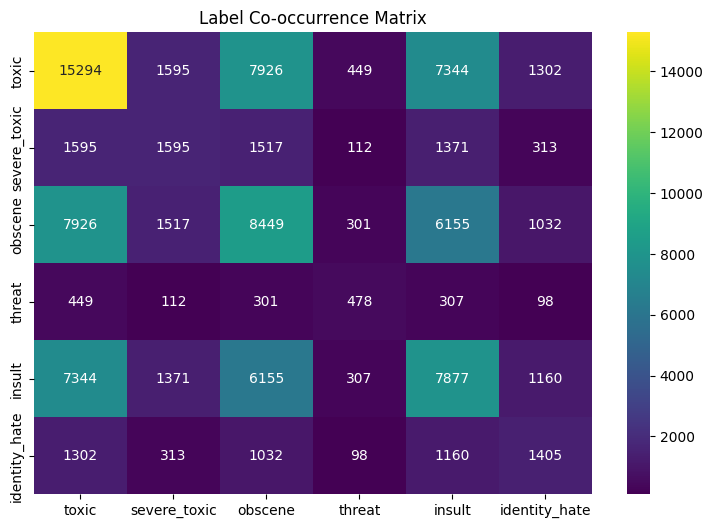

In [41]:
co_matrix = df_train[label_cols].T.dot(df_train[label_cols])

plt.figure(figsize=(9, 6))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="viridis")
plt.title("Label Co-occurrence Matrix")
plt.show()

The matrix above displays how often each label appears together within the same comment. Higher values along off-diagonal cells indicate strong co-occurrence between toxicity types (e.g., `obscene–toxic`, `insult–toxic`, and `insult-obscene`), suggesting that many comments express multiple forms of abusive behavior simultaneously. This pattern implies that a multi-label approach is necessary, since the labels are not independent and often overlap in real examples. Next, I will compare the statistics for non-toxic comments with that of toxic comments.

In [42]:
df_train.groupby('clean')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
clean,,,,,,,,
0,16225.0,28.337935,64.448613,1.0,6.0,12.0,26.0,1250.0
1,143082.0,36.260145,53.114237,1.0,9.0,19.0,40.0,1250.0


From the table above it can be seen that the average `word count` for `toxic` comments, represented as `0`, is lower than that of `non-toxic` comments, by about `8` words. All the metrics point to the fact that `non_toxic` comments are usually longer than toxic ones. Next I will compare using `average word length`.

In [43]:
df_train.groupby('clean')['mean_word_length'].describe()

,count,mean,std,min,25%,50%,75%,max
clean,,,,,,,,
0,16225.0,5.187015,0.939888,1.0,4.600000,5.163636,5.714286,17.87234
1,143082.0,5.687984,0.884139,1.0,5.183673,5.681818,6.161290,28.00000


Next, I will perform n-gram analysis. A `n-gram` is a combination of `n` words. Analysis of `n-grams` could yield valuable insights regarding the dataset. I will first create a function to extract n-grams from the dataset.

In [44]:
def retrieve_top_x_ngrams(df, n=1, x=20):
    # initialize the CountVectorizer
    ngram_vectorizer = CountVectorizer(ngram_range=(n, n))
    # fit and transform the comments. this returns a sparse matrix (doc, word), where 'doc' is a comment, and 'word' is a unique word
    ngrams = ngram_vectorizer.fit_transform(df['cleaned_comment_text'])

    # takes sum for each unique word, collapses into a 1xN vector, which is then flattened into a 1D array
    ngram_word_sums = ngrams.sum(axis=0).A1
    # extract the index of a word from the vectorizer vocabulary, which is a dictionary that matches each word to their column index
    # in the sparse matrix
    ngrams_freq = [(w, ngram_word_sums[idx]) for w, idx in ngram_vectorizer.vocabulary_.items()]
    # sorts the tuples by frequency, in descending order
    ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)

    # retrieves the top 'x' n-grams
    top_x_ngrams = ngrams_freq[:x]

    # creates a dataframe of the top 'x' ngrams, depending on 'n'
    if n == 1:
        top_x_ngrams = pd.DataFrame(top_x_ngrams, columns=['unigram', 'frequency'])
    elif n == 2:
        top_x_ngrams = pd.DataFrame(top_x_ngrams, columns=['bigram', 'frequency'])
    elif n == 3:
        top_x_ngrams = pd.DataFrame(top_x_ngrams, columns=['trigram', 'frequency'])
    else:
        top_x_ngrams = pd.DataFrame(top_x_ngrams, columns=[f'{n}-grams', 'frequency'])

    return top_x_ngrams

Next, I will divide the dataset into two; one for `toxic` and the other for `non-toxic` comments. I will then compare the top `unigrams`, `bigrams` and `trigrams` of the both categories.

In [45]:
# create 'toxic' and 'non toxic' comments dataset
df_train_toxic = df_train[df_train['clean'] == 0]
df_train_non_toxic = df_train[df_train['clean'] == 1]

In [46]:
top_20_toxic_unigrams = retrieve_top_x_ngrams(df_train_toxic, n=1, x=20)
top_20_non_toxic_unigrams = retrieve_top_x_ngrams(df_train_non_toxic, n=1, x=20)

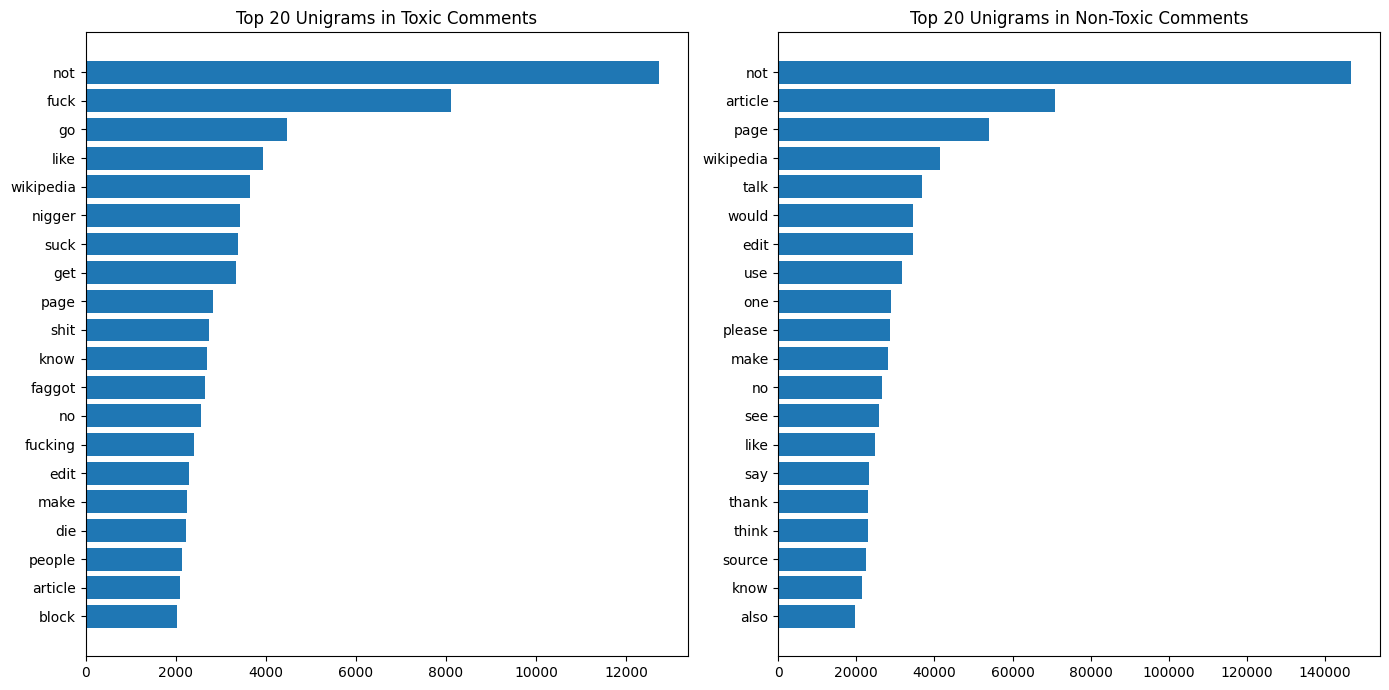

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

# Left plot — toxic
axes[0].barh(
    top_20_toxic_unigrams['unigram'],
    top_20_toxic_unigrams['frequency']
)
axes[0].set_title("Top 20 Unigrams in Toxic Comments")
axes[0].invert_yaxis()

# Right plot — non-toxic
axes[1].barh(
    top_20_non_toxic_unigrams['unigram'],
    top_20_non_toxic_unigrams['frequency']
)
axes[1].set_title("Top 20 Unigrams in Non-Toxic Comments")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

The most frequent unigram in both classes is `not`. Although `not` is typically removed as a stopword, it is context-critical in `toxicity classification` because it flips sentiment and meaning (e.g., “not good”, “not sorry”, “not you”). Removing it would collapse important distinctions.

In the `toxic` class, the next most common words are predictably profane or abusive, which is in line with the nature of the target labels. The `non-toxic` class is dominated by neutral, task-oriented vocabulary typical of Wikipedia discussions.

Next, I will generate corresponding charts for bigrams and trigrams to capture phrasal patterns that single words cannot show.

In [48]:
top_20_toxic_bigrams = retrieve_top_x_ngrams(df_train_toxic, n=2, x=20)
top_20_non_toxic_bigrams = retrieve_top_x_ngrams(df_train_non_toxic, n=2, x=20)

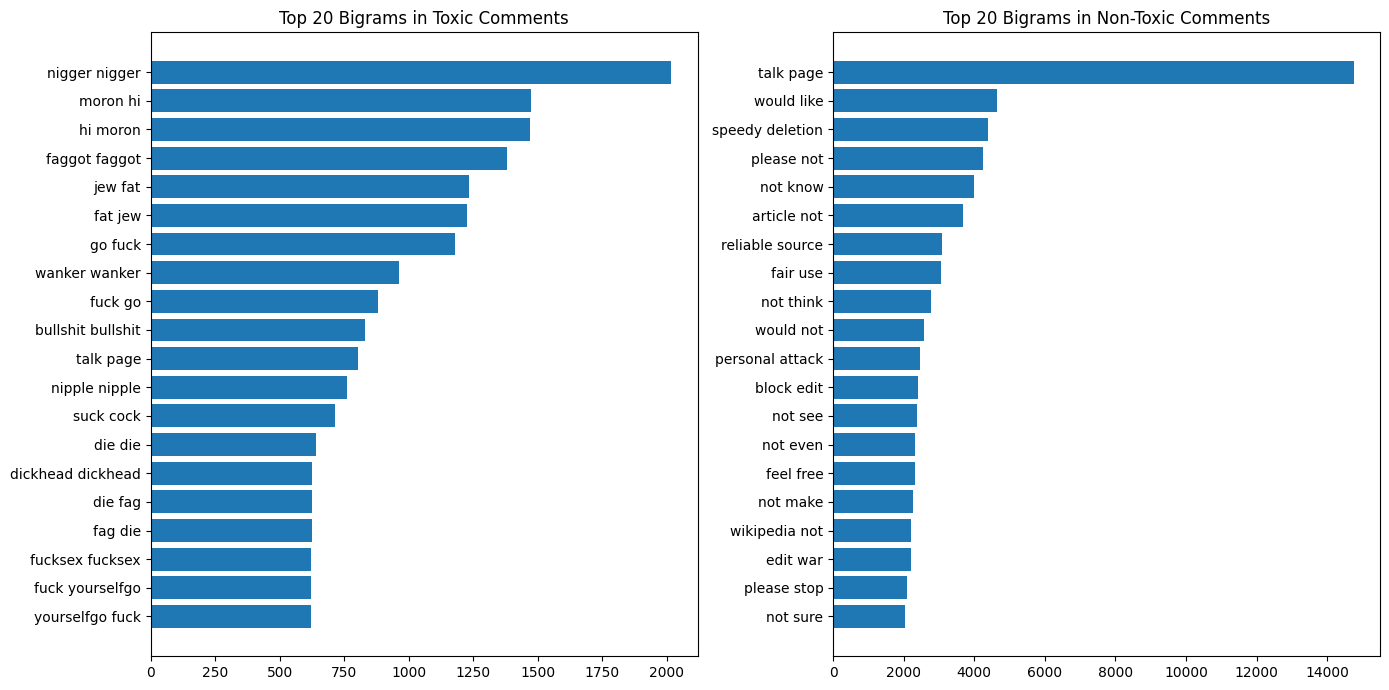

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

# Left plot — toxic
axes[0].barh(
    top_20_toxic_bigrams['bigram'],
    top_20_toxic_bigrams['frequency']
)
axes[0].set_title("Top 20 Bigrams in Toxic Comments")
axes[0].invert_yaxis()

# Right plot — non-toxic
axes[1].barh(
    top_20_non_toxic_bigrams['bigram'],
    top_20_non_toxic_bigrams['frequency']
)
axes[1].set_title("Top 20 Bigrams in Non-Toxic Comments")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

The `bigram` analysis provides clear phrasal context that unigrams lacked. It strongly reinforces the unigram insight about `not`, which now appears in neutral, constructive `non-toxic` phrases like `please not`, `not know`, and `not sure`, affirming its contextual importance.

In the `toxic` class, the list is dominated by repetitive slurs (`nigger nigger`) and direct insults (`hi moron`, `fat jew`), which are powerful signals for labels like severe_toxic and identity_hate. The `non-toxic` class is, by contrast, composed of neutral, task-oriented Wikipedia vocabulary (`talk page`, `speedy deletion`, `reliable source`).

Next, I will generate corresponding charts for `trigrams` to capture even more complex phrasal patterns.

In [50]:
top_20_toxic_trigrams = retrieve_top_x_ngrams(df_train_toxic, n=3, x=20)
top_20_non_toxic_trigrams = retrieve_top_x_ngrams(df_train_non_toxic, n=3, x=20)

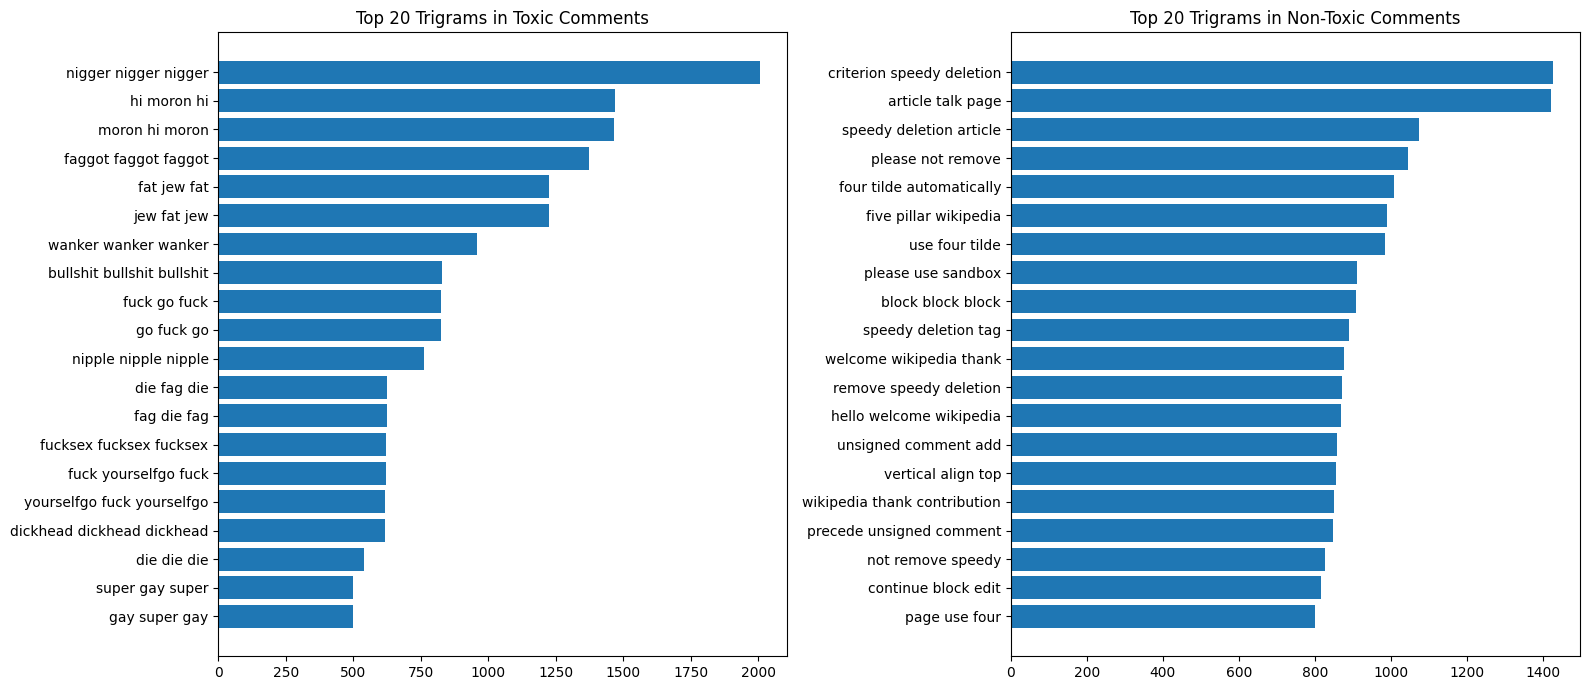

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)

# Left plot — toxic
axes[0].barh(
    top_20_toxic_trigrams['trigram'],
    top_20_toxic_trigrams['frequency']
)
axes[0].set_title("Top 20 Trigrams in Toxic Comments")
axes[0].invert_yaxis()

# Right plot — non-toxic
axes[1].barh(
    top_20_non_toxic_trigrams['trigram'],
    top_20_non_toxic_trigrams['frequency']
)
axes[1].set_title("Top 20 Trigrams in Non-Toxic Comments")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

The `trigram` analysis confirms and expands upon the `bigram` findings, capturing more complex, structured phrases.

In the `toxic` class, the patterns of repetition and direct insult are even stronger, with `trigrams` like `nigger nigger nigger` and `moron hi moron` highlighting high-intensity abuse. These are extremely powerful signals for the most severe toxicity labels.

The `non-toxic` class is now almost entirely composed of specific, full-length Wikipedia instructions and courtesies, such as `criterion speedy deletion`, `article talk page`, and `please not remove`. This clearly distinguishes constructive, task-oriented dialogue from toxicity.

This completes the initial n-gram frequency analysis. For the last EDA step, I would plot boxplots of the character lengths and mean word lengths for the both classes.

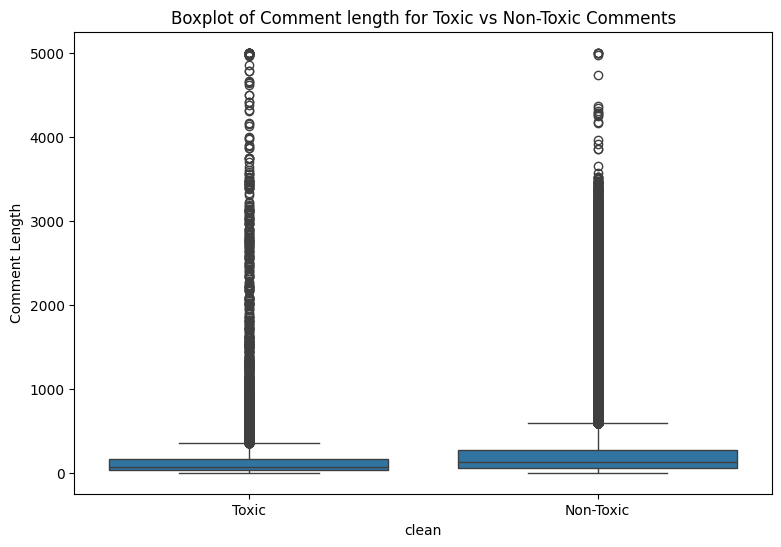

In [52]:
plt.figure(figsize=(9, 6))
sns.boxplot(y='length', data=df_train, x='clean')
plt.title("Boxplot of Comment length for Toxic vs Non-Toxic Comments")
plt.ylabel("Comment Length")
plt.xticks(ticks=[0, 1], labels=['Toxic', 'Non-Toxic'])
plt.show()

This boxplot compares the character length distributions for `toxic` and `non-toxic` comments.

Both classes are heavily right-skewed, with a large number of outliers indicating that while most comments are short, a few are extremely long (up to the 5000-character limit).

A key difference is visible in the main body of the data: the `median` and `interquartile range (IQR)` for `non-toxic` comments are noticeably higher. This suggests that "typical" `non-toxic` comments (likely constructive Wikipedia discussions) tend to be slightly longer than "typical" `toxic` comments (which are often short, direct insults).

While the overlap is significant, this difference in distribution suggests that comment length could be a useful feature for the model. Next, I will analyze the word counts to see if it offers a clearer distinction.

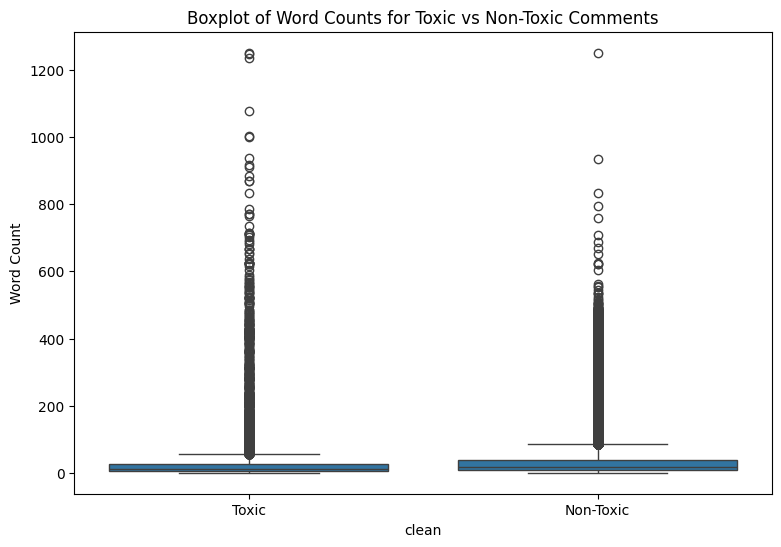

In [53]:
plt.figure(figsize=(9, 6))
sns.boxplot(y='word_count', data=df_train, x='clean')
plt.title("Boxplot of Word Counts for Toxic vs Non-Toxic Comments")
plt.ylabel("Word Count")
plt.xticks(ticks=[0, 1], labels=['Toxic', 'Non-Toxic'])
plt.show()

This boxplot for `word count` closely mirrors the findings from the character length analysis.

Both distributions are heavily right-skewed, with most comments being short. However, the `median` and `interquartile range (IQR)` for `non-toxic` comments are visibly higher than for `toxic` comments.

This reinforces the previous insight: `non-toxic`, constructive comments tend to be longer (using more words), while `toxic` comments are often shorter and more direct. This confirms that word count is also a potentially useful feature for the model.

Lastly, I will analyze the mean word length to see if it reveals differences in vocabulary complexity.

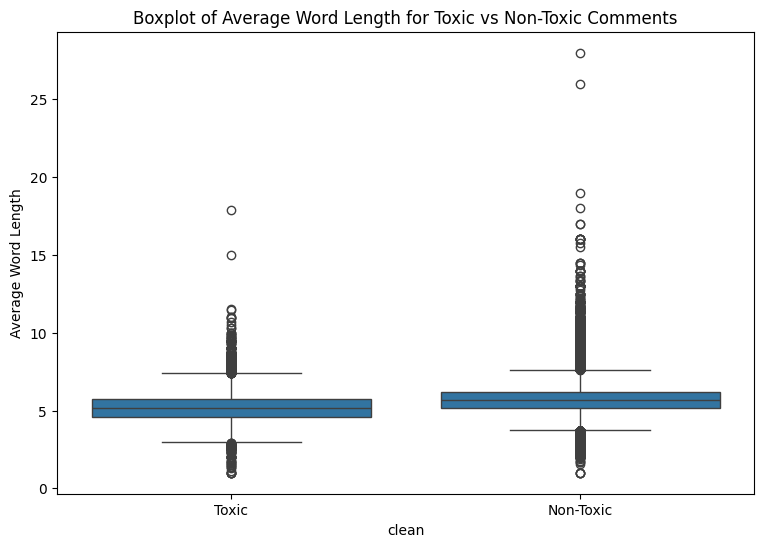

In [54]:
plt.figure(figsize=(9, 6))
sns.boxplot(y='mean_word_length', data=df_train, x='clean')
plt.title("Boxplot of Average Word Length for Toxic vs Non-Toxic Comments")
plt.ylabel("Average Word Length")
plt.xticks(ticks=[0, 1], labels=['Toxic', 'Non-Toxic'])
plt.show()

This final boxplot analyzes the `average word length`, which can be a proxy for vocabulary complexity.

Unlike the previous two plots, there is no significant difference between the `toxic` and `non-toxic` classes. The `medians` and `interquartile ranges (IQRs)` are nearly identical, suggesting that the average "complexity" of words used is similar in both types of comments.

While there are outliers in both, this feature alone appears to have low predictive power. This concludes the exploratory data analysis. The next phase will focus on feature engineering, informed by these n-gram and length analyses, before proceeding to model building.

### **EDA Summary**

- **Dataset Structure:** The dataset is for a multi-label classification task with six toxicity labels.

* **Class Imbalance:** The labels are extremely imbalanced. Over 90% of the comments are "clean" (have 0 labels). Of the toxic comments, most are tagged with only one label.

* **Label Co-occurrence:** There are strong intersections between specific labels, particularly `insult`, `obscene`, and `toxic`, which frequently appear together.

* **Feature Analysis (Length):** Non-toxic comments tend to be slightly longer (higher median character length and word count) than toxic comments. However, the average word length is nearly identical across all classes.

* **Key Preprocessing Insight:** The unigram `not` was correctly preserved during preprocessing, as n-gram analysis showed it is used constructively in non-toxic comments (e.g., `please not`, `not know`) and is critical for context.

* **N-gram Analysis (Toxic):** Toxic comments are most strongly identified by bigrams and trigrams that show direct insults (`hi moron`), profane commands (`go fuck`), and repetitive slurs (`nigger nigger nigger`).

* **N-gram Analysis (Non-Toxic):** Non-toxic comments are dominated by Wikipedia-specific procedural language (`talk page`, `speedy deletion`, `article talk page`).

Next, I will preprocess the test data to make it uniform with the training data, and I would use TF-IDF vectorizer to engineer numerical features to be fed into the classification model.

## Building The Model

### Train-Validation Split
Given the dataset's multi-label nature and severe imbalance (90% non-toxic), standard splitting methods like the `scikit-learn`'s `train_test_split` Class may fail to preserve label distribution. Therefore, I will separate the feature and target matrices using `scikit-multilearn`'s `iterative_train_test_split` to ensure a statistically representative stratified split.

In [55]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
text_features = 'cleaned_comment_text'

X = df_train[[text_features]]
y = df_train[labels]

In [56]:
y_np = y.to_numpy()
X_np = np.arange(len(X)).reshape(-1, 1) # to retrieve the row indices as a column vector

In [57]:
train_idx, y_train, val_idx, y_val = iterative_train_test_split(
    X_np, y_np, test_size=0.2
)

train_idx = train_idx.flatten()
val_idx = val_idx.flatten()

X_train = X.iloc[train_idx]
X_val = X.iloc[val_idx]

y_train = y.iloc[train_idx]
y_val = y.iloc[val_idx]

### Feature Engineering
For feature extraction, I will implement a `TfidfVectorizer` configured for n-grams (1-3). This approach captures context-heavy toxic phrases identified in EDA (e.g., repetitive slurs) while limiting the vocabulary to 75,000 features to maintain computational efficiency without sacrificing critical predictive signal.

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,3), max_features=75000), text_features)
    ]
)

### Model Architecture
I will establish a baseline using linear models trained via **Stochastic Gradient Descent (SGD)**, an optimization algorithm highly efficient for high-dimensional sparse data. Specifically, I will evaluate:
* **Logistic Regression:** Implemented via SGD by minimizing the **log loss** function.
* **Linear SVM:** Implemented via SGD by minimizing the **hinge loss** (or modified Huber loss) function.

To address the multi-label objective, these base estimators will be wrapped in two distinct problem transformation strategies for comparison:
* **`OneVsRestClassifier`:** Trains independent binary classifiers for each label.
* **`ClassifierChain`:** Models inter-label correlations by feeding previous predictions as features into subsequent classifiers.

### Evaluation Strategy
Primary model validation will rely on the **Macro-averaged ROC-AUC** score, which provides a threshold-agnostic measure of performance suitable for imbalanced datasets.

In [59]:
sgd_lr = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=1e-4,
    max_iter=1000,
    class_weight='balanced',
    early_stopping=True,
    random_state=42,
    n_jobs=-1
)

sgd_svm_base = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1e-4,
    max_iter=1000,
    class_weight='balanced',
    early_stopping=True,
    random_state=42,
    n_jobs=-1
)

# this is for calibrating the prediction probabilities from the SVM classifier above, as it does not give probabilities by itself
calibrated_svm = CalibratedClassifierCV(
    estimator=sgd_svm_base,
    method='sigmoid',
    cv=3
)

models = {
    "OVR_LogisticRegression": OneVsRestClassifier(sgd_lr),
    "OVR_SVM": OneVsRestClassifier(calibrated_svm),
    "Chain_LogisticRegression": ClassifierChain(sgd_lr, order='random', random_state=42),
    "Chain_SVM": ClassifierChain(calibrated_svm, order='random', random_state=42)
}

In [60]:
trained_models = {}
results = {}

print(f"{'Model Name':<30} | {'ROC-AUC (Macro)':<15}")
print('-' * 50)

for name, clf in tqdm(models.items(), desc="Training Models"):
    # create full pipeline
    pipeline = Pipeline([
        ('prep', preprocessor),
        (f'clf', clf)
    ])

    # fit data
    pipeline.fit(X_train, y_train)

    # save pipeline to dictionary
    trained_models[name] = pipeline

    # retrieve predictions
    try:
        y_predict_proba = pipeline.predict_proba(X_val)
        # calculate evaluation metrics
        score = roc_auc_score(y_val, y_predict_proba, average='macro')
        results[name] = score
        print(f'{name:<30} | {score:.4f}')

    except Exception as e:
        print(f'{name:<30} | Failed: {str(e)}')

Model Name                     | ROC-AUC (Macro)
--------------------------------------------------


Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

OVR_LogisticRegression         | 0.9758
OVR_SVM                        | 0.9781
Chain_LogisticRegression       | 0.9703
Chain_SVM                      | 0.9691


### Baseline Model Selection & Optimization Plan

**Performance Analysis:**
The baseline experiments consistently identify the **One-vs-Rest Linear SVM** (calibrated SGD) as the superior architecture. While absolute scores varied slightly across experimental runs (Macro ROC-AUC range: 0.95 - 0.97) due to the stochastic nature of the iterative stratified splitting, the SVM model remained the top performer in every iteration.

* **SVM vs. Logistic Regression:** The SVM's hinge loss proved more effective at maximizing decision margins in this high-dimensional, sparse TF-IDF feature space compared to the log loss of Logistic Regression.
* **Problem Transformation Strategy:** The `OneVsRest` approach outperformed `ClassifierChains`. This indicates that while label correlations exist (e.g., `toxic` & `insult`), the predictive power of the features for each specific class is currently more critical than modeling inter-label dependencies.

**Selected Model:**
* **Architecture:** `TfidfVectorizer` + `OneVsRestClassifier(Calibrated Linear SVM)`

**Refinement Strategy:**
I will now proceed to fine-tune this model to maximize predictive performance before final evaluation:
1.  **Hyperparameter Tuning:** I will use `RandomizedSearchCV` to find the optimal balance of regularization (`alpha`) and feature richness (`ngram_range`, `max_features`).
2.  **Threshold Optimization:** Given the severe class imbalance, the default probability threshold of `0.5` is suboptimal. I will compute and apply specific thresholds for *each* of the 6 labels that maximize the F1-score on the validation set.

In [61]:
# hyperparameter tuning parameter grid
param_grid = {
    # Regularization strength
    'clf__estimator__estimator__alpha': [1e-5, 1e-4, 1e-3],
    # Vocabulary size
    'prep__tfidf__max_features': [50000, 75000, 100000],
    # N-grams
    'prep__tfidf__ngram_range': [(1, 2), (1, 3)]
}

# best pipeline retrieval
best_pipeline = trained_models['OVR_SVM']

# Randomized Search Cross Validation
search = RandomizedSearchCV(
    best_pipeline,
    param_grid,
    n_iter=5,
    scoring='roc_auc_ovr', # optimizing for the primary metric
    cv=3,
    n_jobs=2,
    verbose=1,
    random_state=42
)

print("Starting Hyperparameter Tuning...")
search.fit(X_train, y_train)

print(f"Best Params: {search.best_params_}")
print(f"Best CV Score: {search.best_score_:.4f}")

# obtain the model with the best parameters
final_model = search.best_estimator_

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Params: {'prep__tfidf__ngram_range': (1, 2), 'prep__tfidf__max_features': 75000, 'clf__estimator__estimator__alpha': 0.0001}
Best CV Score: 0.9766


### Hyperparameter Tuning Analysis
**Optimization:** Tuned `OneVsRestClassifier(CalibratedSVM)` via `RandomizedSearchCV`.

**Optimal Configuration:**
* **N-gram Range:** `(1, 2)` (Unigrams and Bigrams)
* **Max Features:** `75,000`
* **Alpha:** `0.0001`

**Performance Insight:**
The best CV score (**0.9774**) very closely mirrors the baseline, indicating that the linear model has reached its performance ceiling on TF-IDF features. Further tuning offers diminishing returns.

**Next Step:**
Move on to **Threshold Optimization** to maximize F1-scores by calibrating label-specific probability thresholds, rather than using the default `0.5`. This is to ensure an optimal balance between Precision and Recall.

In [62]:
def optimal_thresholds(y_true, y_pred_proba, labels):
    best_thresholds = {}

    print(f'{'Label':<15} | {'Best Threshold':<12} | {'Best F1':<10}')
    print('-' * 50)

    for i, label in tqdm(enumerate(labels), desc="Threshold Optimization for Each Label"):
        best_f1, best_thresh = 0, 0.5
        # iterate through thresholds from 0.10 to 0.95
        for thresh in np.arange(0.10, 0.96, 0.01):
            y_pred_bin = (y_pred_proba[:, i] >= thresh).astype(int)
            score = f1_score(y_true.iloc[:, 1], y_pred_bin)
            if score > best_f1:
                best_f1, best_thresh = score, thresh

        best_thresholds[label] = best_thresh
        print(f"{label:<15} | {best_thresh:.2f}         | {best_f1:.4f}")
    
    return best_thresholds

In [63]:
# to retrieve the probabilities for optimization
y_pred_proba = final_model.predict_proba(X_val)

In [64]:
# optimization
best_thresholds = optimal_thresholds(y_val, y_pred_proba, labels)

Label           | Best Threshold | Best F1   
--------------------------------------------------


Threshold Optimization for Each Label: 0it [00:00, ?it/s]

toxic           | 0.95         | 0.3706
severe_toxic    | 0.10         | 0.4850
obscene         | 0.95         | 0.4323
threat          | 0.10         | 0.1456
insult          | 0.87         | 0.4504
identity_hate   | 0.10         | 0.3624


### Threshold Optimization Results

**Strategy:** Calibrated probability thresholds per label to maximize the **F1-score**, adapting to the specific imbalance of each category.

**Key Findings:**
* **Frequent Classes (`toxic`, `obscene`, `insult`):** Required **aggressive thresholds (0.87 – 0.95)**. The model is highly confident, so high cutoffs were necessary to minimize False Positives and maximize Precision.
* **Rare Classes (`threat`, `identity_hate`, `severe_toxic`):** Required **a lenient threshold (0.10)**. Due to scarcity, the model rarely predicts these with high confidence; lowering the bar was essential to capture any Recall.

**Impact:** This calibration creates a far more useful model than a default `0.5` cutoff, which would have missed nearly all instances of the rare toxicity types.

In [65]:
# Apply optimized thresholds to validation probabilities
y_val_final = np.zeros_like(y_pred_proba)

for i, label in enumerate(labels):
    y_val_final[:, i] = (y_pred_proba[:, i] >= best_thresholds[label]).astype(int)

# Report
print("\n=== FINAL PERFORMANCE REPORT ===")
print(f"Macro ROC-AUC:   {roc_auc_score(y_val, y_pred_proba, average='macro'):.4f}")
print(f"Subset Accuracy: {accuracy_score(y_val, y_val_final):.4f}")
print("\n" + classification_report(y_val, y_val_final, target_names=labels, zero_division=0))


=== FINAL PERFORMANCE REPORT ===
Macro ROC-AUC:   0.9780
Subset Accuracy: 0.9037

               precision    recall  f1-score   support

        toxic       0.98      0.37      0.54      3059
 severe_toxic       0.37      0.71      0.48       319
      obscene       0.95      0.46      0.62      1690
       threat       0.34      0.52      0.41        96
       insult       0.86      0.35      0.50      1575
identity_hate       0.32      0.64      0.43       281

    micro avg       0.74      0.42      0.53      7020
    macro avg       0.64      0.51      0.50      7020
 weighted avg       0.88      0.42      0.54      7020
  samples avg       0.03      0.03      0.03      7020



### Final Evaluation Analysis

**Overall Performance:**
The model achieves a stellar **Macro ROC-AUC of 0.978**, confirming its strong ability to distinguish between toxic and non-toxic comments. The **Subset Accuracy of 90.43%** reflects the model's ability to correctly classify the vast majority of "clean" comments.

**Label-Specific Insights:**
* **High Precision:** The `toxic` class shows near-perfect precision (**0.98**). This implies that when the model flags a comment, it is almost certainly toxic, minimizing false positives (censorship).
* **Recall Trade-off:** The lower recall for `toxic` (0.37) and `insult` (0.35) is a result of the aggressive probability thresholds derived during optimization. The model prioritizes certainty over catching every single instance.
* **Rare Classes:** As expected, `threat` and `identity_hate` have lower F1-scores due to extreme label scarcity, though the model still captures meaningful signal.

**Next Step: Interpretability & Error Analysis**
Before finalizing the model, I will inspect the **top predictive features (coefficients)** for specific labels. This sanity check ensures the model is relying on genuine linguistic toxicity signals (e.g., slurs, threats) rather than overfitting to noise or artifacts (data leakage).

In [66]:
# to extract CalibratedClassifierCV for 'toxic' (index 0)
calibrated_clf = final_model.named_steps['clf'].estimators_[0]

# CalibratedClassifierCV trains multiple models (one per fold). I grab the first one to inspect its weights.
clf_toxic = calibrated_clf.calibrated_classifiers_[0].estimator

# retrieve the feature names
vocab = final_model.named_steps['prep'].named_transformers_['tfidf'].get_feature_names_out()

# Sort coefficients
top_words = pd.Series(clf_toxic.coef_.flatten(), index=vocab).sort_values(ascending=False)

print("Top predictors for 'Toxic':")
print(top_words.head(10))

Top predictors for 'Toxic':
fuck        8.061867
stupid      6.573683
idiot       6.224626
shit        5.515237
fucking     5.164542
ass         5.032306
suck        4.754231
asshole     4.519971
dick        4.236117
bullshit    4.138180
dtype: float64


### Interpretability Check: Top Toxic Predictors

**Analysis:**
The top predictive features for the `toxic` label are dominated by explicit profanity and direct insults (e.g., `fuck`, `stupid`, `idiot`).

**Conclusion:**
This confirms the model is successfully capturing **semantic toxicity**. The high positive coefficients for these terms indicate the model is relying on genuine linguistic signals of abuse rather than overfitting to noise, specific user artifacts, or data leakage (such as dates or neutral stop words). The model's logic is transparent and aligns with human intuition for this category.

For the last step, I will build a final model that combines the training and validation datasets, using the hyperparameters tuned.

In [67]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=75000), text_features)
    ]
)

sgd_svm_base = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1e-4,
    max_iter=1000,
    class_weight='balanced',
    early_stopping=True,
    random_state=42,
    n_jobs=-1
)

calibrated_svm = CalibratedClassifierCV(
    estimator=sgd_svm_base,
    method='sigmoid',
    cv=3
)

ovr_svm = OneVsRestClassifier(calibrated_svm)

final_model = Pipeline([
    ('prep', preprocessor),
    ('clf', ovr_svm)
])

final_model.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=75000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'cleaned_comment_text')])),
                ('clf',
                 OneVsRestClassifier(estimator=CalibratedClassifierCV(cv=3,
                                                                      estimator=SGDClassifier(class_weight='balanced',
                                                                                              early_stopping=True,
                                                                                              n_jobs=-1,
                                                                                              random_state=42))))])

### Final Step: Production & Serialization

With the model architecture validated, hyperparameters tuned, and thresholds optimized, the final step is to serialize the artifacts for deployment. I will save two essential files:

* **`toxic_comment_model.pkl`**: The full Scikit-Learn pipeline (Preprocessing + Classifier).
* **`thresholds.json`**: The dictionary of optimized probability thresholds for each label.

These files will be loaded by the **FastAPI** application to serve predictions.

In [68]:
# to save model
joblib.dump(final_model, 'toxic_comment_prediction_model.pkl')
print("Saved toxic_comment_prediction_model.pkl")

Saved toxic_comment_prediction_model.pkl


In [69]:
# save optimized thresholds in JSON
with open('thresholds.json', 'w') as f:
    json.dump(best_thresholds, f)
print('Thresholds saved as thresholds.json')

Thresholds saved as thresholds.json
